In [1]:
# import required libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def plotmyimage(img,title=''):
    #This function is used during the debug phase. 
    #This just plots the image 
    plt.imshow(img,cmap='gray') # draws in grayscale if it is M x N x 1, draws in color if RGB
    plt.title(title)
    plt.show()
    
# preparing for camera calibration
# gather object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    #plotmyimage(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        # Find the chessboard corners
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plotmyimage(img,fname)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
retval,cameraMatrix,distCoeffs,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,img.shape[0:2],None,None)


    

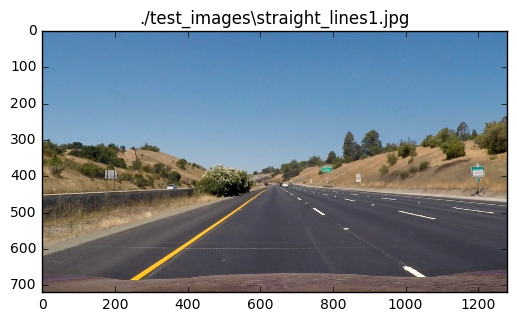

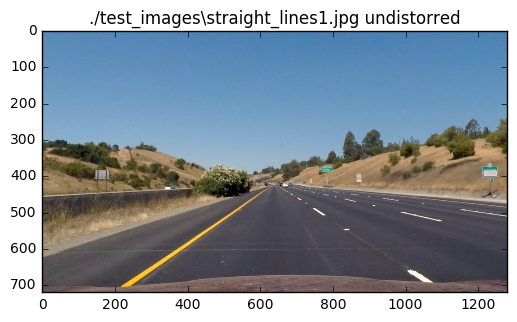

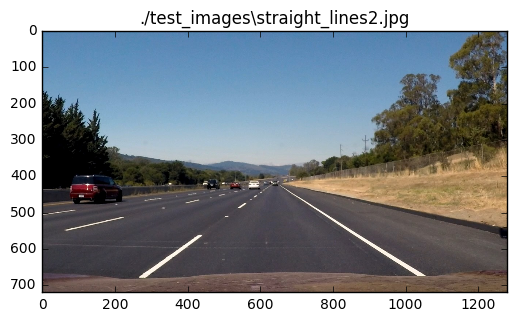

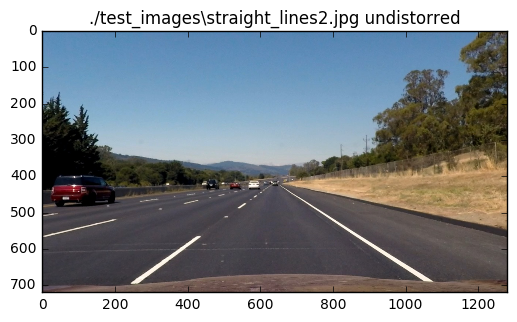

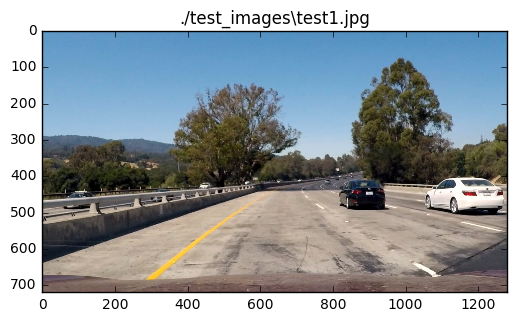

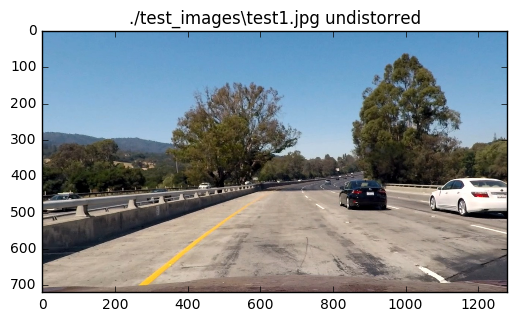

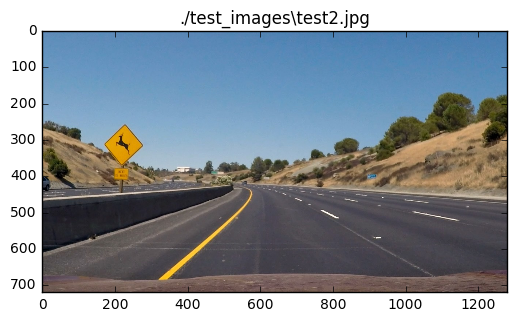

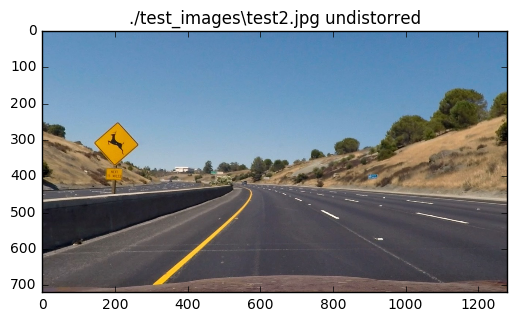

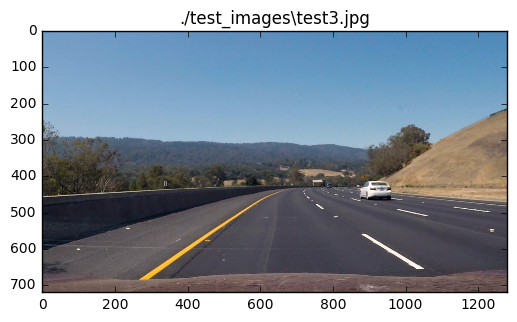

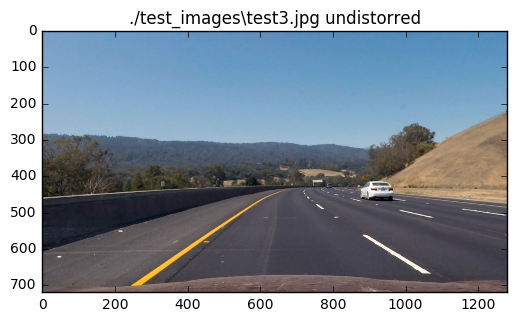

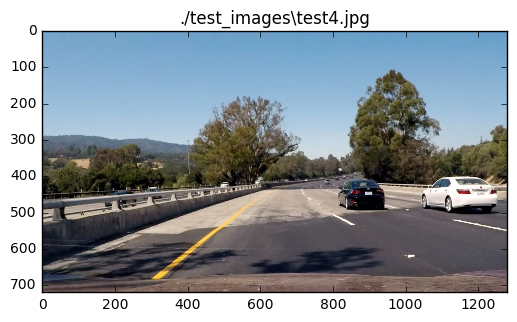

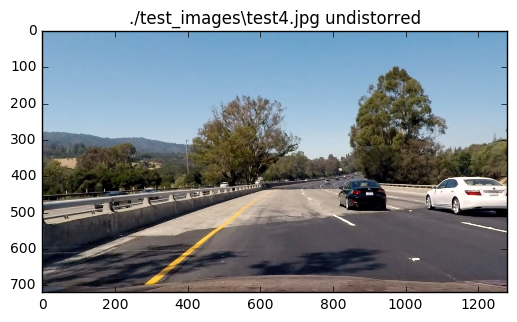

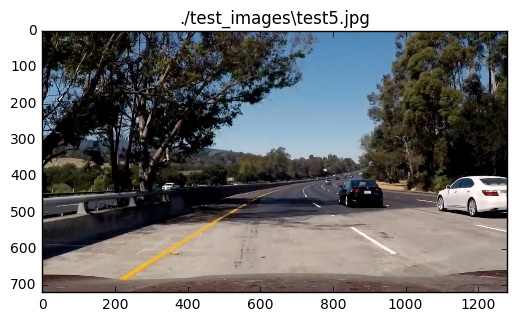

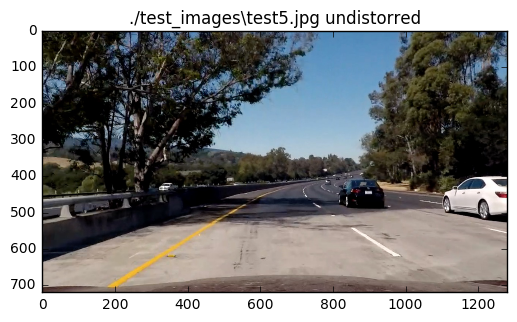

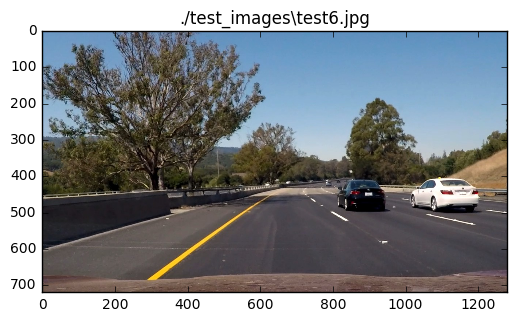

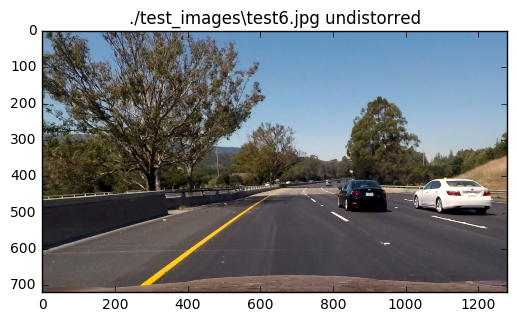

In [2]:


#applying the distorsion correction to the test images
images = glob.glob('./test_images/*.jpg')

for fname in images:
    img=mpimg.imread(fname)
    plotmyimage(img,fname)
    img1 =  cv2.undistort(img, cameraMatrix,distCoeffs,None,cameraMatrix) 
    plotmyimage(img1,fname+' undistorred')

In [3]:

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #This function returns thresholded sobel threshold applied in x or y direction
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sab=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient=='y':
        sab=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    sabb=np.uint8(255*sab/np.max(sab))
    

    binary_output = np.zeros_like(sabb)
    binary_output[(sabb >= thresh_min) & (sabb <= thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    #This function returns thresholded absolute sobel applied in both x, y directions
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #This function returns thresholded direction of the sobel 
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def S_threshold(img,  thresh=(80, 250)):
    #This function returns thresholded S channel of the image in HLS image space
    # Grayscale
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > 80) & (S <= 250)] = 1
    # Return the binary image
    return binary

#processing all the images for applying thresholds, and creating combined binary, independently for each image.
#the following is the sample code used for debugging
for fname in images:
    img=mpimg.imread(fname)
    #plotmyimage(img,fname)
    
    img =  cv2.undistort(img, cameraMatrix,distCoeffs,None,cameraMatrix) 

    sxbinary=abs_sobel_thresh(img,'x',20,210)
    #plotmyimage(sxbinary,fname+' abs sobelx threshold')
    
    sybinary=abs_sobel_thresh(img,'y',20,210)
    #plotmyimage(sxbinary,fname+' abs sobely threshold')
    
    sxmag=mag_thresh(img, sobel_kernel=7, mag_thresh=(20,200))
    #plotmyimage(sxmag,fname+' sobel magnitude threshold')
    
    sxdir=dir_threshold(img, sobel_kernel=7, thresh=(0.3, 1.4))
    #plotmyimage(sxdir,fname+' sobel direction threshold')
    
    combined = np.zeros_like(sxdir)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((sxmag == 1) & (sxdir == 1))] = 1
    #plotmyimage(combined,fname+' combining thresholds')

    binary=S_threshold(img,thresh=(150,250))
    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary == 1) | (sxbinary == 1)] = 1
    #plotmyimage(binary,' S-channel,SobelX,SobelDir,SobelMag  thresholds')


In [4]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def process_image(image,first=0):
    #defing few globals that are used
    global left_fit
    global right_fit
    global cameraMatrix
    global distCoeffs
    
    #creating a zero initialized image sized array
    #tmpimage=np.copy(image)*0
    imshape=image.shape
    #plotmyimage(image,'original image')#for debugging only        
    
    #undistorting the image
    img =  cv2.undistort(image, cameraMatrix,distCoeffs,None,cameraMatrix) 
    
    
    #applying thresholds
    sxbinary=abs_sobel_thresh(img,'x',45,210)
    #plotmyimage(sxbinary,fname+' abs sobelx threshold')
    combined_binary = np.zeros_like(sxbinary)
    sxmag=mag_thresh(img, sobel_kernel=7, mag_thresh=(50,200))
    #plotmyimage(sxmag,fname+' sobel magnitude threshold')
    sxdir=dir_threshold(img, sobel_kernel=7, thresh=(0.6, 1.4))
    #plotmyimage(sxdir,fname+' sobel direction threshold')
    binary=S_threshold(img,thresh=(150,250))
    combined_binary[(binary == 1) | (sxbinary == 1)| ((sxmag == 1) & (sxdir == 1))] = 1
    
    #generating coordinates for source, destination points for perspective transformation 
    src=np.float32([[200,720],[595,450],[688,450],[1100,720]])
    #print(src) 
    dst = np.float32([[300,720],[300,0],[1000,0],[1000, 720]])
    #print(dst)

    #generating perspective transform coefficients 
    pt = cv2.getPerspectiveTransform(src, dst)
    pt_inv= cv2.getPerspectiveTransform(dst, src)
    
    #warping the image
    warped = cv2.warpPerspective(combined_binary, pt, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    #plotmyimage(warped)
    binary_warped=warped
    
    #applying the histogram for bottom half of point in the warped image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #use following code if the image is first of the section
    if first==1:

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds) 

    #use the following code if the image is not the first in the sequence
    if first==0:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #generating points and curves for lane boundaries
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #generating colored images for left and right halves
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    #plt.show()

    #creating zero like initialization for color mask
    area_color=np.zeros_like(img)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts.shape)
    #filling the polygon with color
    cv2.fillPoly(area_color, np.int_([pts]), (0,255, 0))
    #uncarping the image of color mask
    imgwarp = cv2.warpPerspective(area_color, pt_inv, (imshape[1], imshape[0]))
    #overlapping the image with color mask
    whtdimg=weighted_img(imgwarp,img)
    
    #identify the point on image closest to the road
    ymax = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*ymax*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*ymax*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature=((left_curverad+ right_curverad)/2)
    #calculate the offset of the camera from the center of image 
    offset=((rightx_base+leftx_base/2) - midpoint) * xm_per_pix
    
    #print( offset)
    #print(curvature)
    
    cv2.putText(whtdimg,"Vehicle is " + str(offset) + " m offset from the center.", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0),3)
    cv2.putText(whtdimg,"Road curvature is " + str(curvature) + " m.", (10,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0),3)
    
    return whtdimg



def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
            


In [5]:
#sample code to test the pipeline on individial images
first=1
left_fit=[]
right_fit=[]
for fname in images:
    img=mpimg.imread(fname)
    #plotmyimage(img)
    bina=process_image(img,first)
    #plotmyimage(bina)
    first=1

In [6]:
from moviepy.editor import *
from IPython.display import HTML
file='project_video.mp4'
white_output = 'output_'+file
#reading, processing, and saving the file
clip1 = VideoFileClip(file)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:49<00:00,  4.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 4min 49s


In [7]:
#displaying the file
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(white_output))
